In [1]:
import sklearn
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.ensemble import RandomTreesEmbedding, HistGradientBoostingRegressor, StackingRegressor, VotingRegressor
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.model_selection import train_test_split
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV, Ridge
from sklearn.model_selection import ParameterGrid, ParameterSampler, RandomizedSearchCV
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, KernelCenterer, RobustScaler
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer, max_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import joblib
from sklearn.model_selection import cross_val_score, KFold, cross_validate, cross_val_predict
from sklearn.pipeline import make_pipeline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random, time
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, max_error
from sklearn.linear_model import LinearRegression

## BEFORE PRUNING

In [3]:
df_all = pd.read_csv('data_all.csv')
x_all = df_all.drop(columns = ["V","α","β"])
y_all = df_all[["V","α","β"]]

x0_train, x0_test, y0_train, y0_test = train_test_split(x_all, y_all,
                                                        random_state = 42, test_size = 0.2)

In [4]:
def max_absolute_error(y_true, y_pred):
    return np.max(np.abs(y_true - y_pred), axis=0)
scaler = StandardScaler()

# Base models (Level Pertama)
base_models = [
    ('random_forest', RandomForestRegressor(n_estimators=250, random_state=42, max_features = 'sqrt')),
    ('gradient_boosting', GradientBoostingRegressor(n_estimators=200, learning_rate=0.0579, random_state=42, max_depth = 5)),
    ('knn', make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=2, weights='distance', algorithm='auto')))
]

# Meta-model (Level Kedua)
# Menggunakan Ridge Regression sebagai meta-model untuk menghindari overfitting
meta_model = Ridge(alpha=0.1)

# Membentuk Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True  # Memasukkan data asli ke meta-model bersama prediksi base models
)

# Untuk multi-output, kita bungkus dengan MultiOutputRegressor
model_all_best = MultiOutputRegressor(stacking_regressor)
start = time.time()
# Training
model_all_best.fit(x0_train, y0_train)
end = time.time()
waktu = (end-start)/60
# Prediction
y0_pred = model_all_best.predict(x0_test)
r2 = r2_score(y0_test, y0_pred, multioutput = 'raw_values')
mae = mean_absolute_error(y0_test, y0_pred, multioutput = 'raw_values')
mse = mean_squared_error(y0_test, y0_pred, multioutput = 'raw_values')
max_ae = max_absolute_error(y0_test, y0_pred)
print(f'R2 : \n Alpha : {r2[1]} \n Beta : {r2[2]} \n V : {r2[0]} ')
print(f'MAE : \n Alpha : {mae[1]} \n Beta : {mae[2]} \n V : {mae[0]} ')
print(f'MSE : \n Alpha : {mse[1]} \n Beta : {mse[2]} \n V : {mse[0]} ')
print('Max AERR : \n', max_ae)
print("Waktu yang dibutuhkan : ", waktu)

R2 : 
 Alpha : 0.9999999518449048 
 Beta : 0.9786085926247874 
 V : 0.9999997006737554 
MAE : 
 Alpha : 0.004298451266537389 
 Beta : 0.550168122812585 
 V : 0.0021246872693424417 
MSE : 
 Alpha : 5.760326756291966e-05 
 Beta : 2.251416282746785 
 V : 6.128302128893325e-05 
Max AERR : 
 V     0.081751
α     0.075188
β    12.733468
dtype: float64
Waktu yang dibutuhkan :  1.3712371945381165


In [6]:
train_score = model_all_best.score(x0_train, y0_train)  
cv_score = cross_val_score(model_all_best, x0_train, y0_train, cv=5, scoring="r2")

print("Training R² Score:", train_score)
print("Cross-Validation Mean R² Score:", cv_score.mean())

Training R² Score: 0.999538750515402
Cross-Validation Mean R² Score: 0.9903200853876084


In [7]:
test_score = model_all_best.score(x0_test, y0_test)
print("Test R² Score:", test_score)

Test R² Score: 0.9928694150478159


In [93]:
y_cv_pred = cross_val_predict(model_all_best, x0_train, y0_train, cv=5)
print ('R2 V CV : ',(r2_score(y0_train['V'], y_cv_pred[:,0])))
print ('R2 Alpha CV : ',(r2_score(y0_train['α'], y_cv_pred[:,1])))
print ('R2 Beta CV : ',(r2_score(y0_train['β'], y_cv_pred[:,2])))
print ('R2 V Test : ',(r2_score(y0_test['V'], y0_pred[:,0])))
print ('R2 Alpha Test : ',(r2_score(y0_test['α'], y0_pred[:,1])))
print ('R2 Beta CV : ',(r2_score(y0_test['β'], y0_pred[:,2])))
print('MAE V CV : ', (mean_absolute_error(y0_train['V'], y_cv_pred[:,0])))
print('MAE Alpha CV : ', (mean_absolute_error(y0_train['α'], y_cv_pred[:,1])))
print('MAE Beta CV : ', (mean_absolute_error(y0_train['β'], y_cv_pred[:,2])))
print('MAE V Test : ', (mean_absolute_error(y0_test['V'], y0_pred[:,0])))
print('MAE Alpha Test : ', (mean_absolute_error(y0_test['α'], y0_pred[:,1])))
print('MAE Beta Test : ', (mean_absolute_error(y0_test['β'], y0_pred[:,2])))1

R2 V CV :  0.9999996494529778
R2 Alpha CV :  0.9999937400854129
R2 Beta CV :  0.9710830236692937
R2 V Test :  0.9999997006737554
R2 Alpha Test :  0.9999999518449048
R2 Beta CV :  0.9786085926247874
MAE V CV :  0.0023309468466022375
MAE Alpha CV :  0.01772298515944459
MAE Beta CV :  0.6731679294271532
MAE V Test :  0.0021246872693424417
MAE Alpha Test :  0.004298451266537389
MAE Beta Test :  0.550168122812585


In [94]:
scoring = {
    'r2': 'r2',
    'mae': make_scorer(mean_absolute_error, greater_is_better=False),      
}
cv_scores = cross_validate(model_all_best, x0_train, y0_train, cv=5, scoring=scoring)

print("Cross-Validation R² Scores:", cv_scores['test_r2'])
print("Mean CV R² Score:", cv_scores['test_r2'].mean())

print("Cross-Validation MAE Scores:", -cv_scores['test_mae'])  
print("Mean CV MAE Score:", -cv_scores['test_mae'].mean())

test_score_r2 = model_all_best.score(x0_test, y0_test)
test_score_mae = mean_absolute_error(y0_test, y0_pred)
print("Test R² Score:", test_score_r2)
print(f"Test MAE: {test_score_mae:.6f}")

Cross-Validation R² Scores: [0.99205099 0.99117346 0.98705731 0.98987342 0.99144525]
Mean CV R² Score: 0.9903200853876084
Cross-Validation MAE Scores: [0.23481945 0.23008494 0.23838737 0.23543095 0.21664706]
Mean CV MAE Score: 0.2310739538110667
Test R² Score: 0.9928694150478159
Test MAE: 0.185530


In [95]:
y0_train_pred = model_all_best.predict(x0_train)
r2_train = r2_score(y0_train, y0_train_pred, multioutput = 'raw_values')
mae_train = mean_absolute_error(y0_train, y0_train_pred, multioutput = 'raw_values')
mse_train = mean_squared_error(y0_train, y0_train_pred, multioutput = 'raw_values')
max_ae_train = max_absolute_error(y0_train, y0_train_pred)
print(f'R2 : \n Alpha : {r2_train[1]} \n Beta : {r2_train[2]} \n V : {r2_train[0]} ')
print(f'MAE : \n Alpha : {mae_train[1]} \n Beta : {mae_train[2]} \n V : {mae_train[0]} ')
print(f'MSE : \n Alpha : {mse_train[1]} \n Beta : {mse_train[2]} \n V : {mse_train[0]} ')
print('Max AERR : \n', max_ae_train)

R2 : 
 Alpha : 0.9999999833433361 
 Beta : 0.9986162715659151 
 V : 0.9999999966369547 
MAE : 
 Alpha : 0.0030708798406465514 
 Beta : 0.2120914229285499 
 V : 0.0004979677798662645 
MSE : 
 Alpha : 2.0941287937836038e-05 
 Beta : 0.1505544641726649 
 V : 6.679040113696319e-07 
Max AERR : 
 V    0.004662
α    0.046060
β    3.650507
dtype: float64


In [5]:
y_pred_df = pd.DataFrame(y0_pred, columns = ["V","α","β"], index = y0_test.index)
y0_pred_10 = y_pred_df[(y_pred_df["V"] >= 8.5) & (y_pred_df["V"] <= 11.5)]
y0_pred_20 = y_pred_df[(y_pred_df["V"] >= 18.5) & (y_pred_df["V"] <= 21.5)]
y0_pred_30 = y_pred_df[(y_pred_df["V"] >= 28.5) & (y_pred_df["V"] <= 31.5)]
y0_pred_40 = y_pred_df[(y_pred_df["V"] >= 38.5) & (y_pred_df["V"] <= 41.5)]
y0_pred_50 = y_pred_df[(y_pred_df["V"] >= 48.5) & (y_pred_df["V"] <= 51.5)]

In [6]:
y0_test_10 = y0_test[(y0_test['V'] >= 8.5) & (y0_test['V'] <= 11.5)]
y0_test_20 = y0_test[(y0_test['V'] >= 18.5) & (y0_test['V'] <= 21.5)]
y0_test_30 = y0_test[(y0_test['V'] >= 28.5) & (y0_test['V'] <= 31.5)]
y0_test_40 = y0_test[(y0_test['V'] >= 38.5) & (y0_test['V'] <= 41.5)]
y0_test_50 = y0_test[(y0_test['V'] >= 48.5) & (y0_test['V'] <= 51.5)]

In [7]:
print(len(y0_test_10), len(y0_pred_10))
print(len(y0_test_20), len(y0_pred_20))
print(len(y0_test_30), len(y0_pred_30))
print(len(y0_test_40), len(y0_pred_40))
print(len(y0_test_50), len(y0_pred_50))
test = len(y0_test_10) + len(y0_test_20) + len(y0_test_30) + len(y0_test_40) + len(y0_test_50)
predict = len(y0_pred_10) + len(y0_pred_20) + len(y0_pred_30) + len(y0_pred_40) + len(y0_pred_50)
if test == predict :
    print('True')

300 300
247 247
266 266
276 276
261 261
True


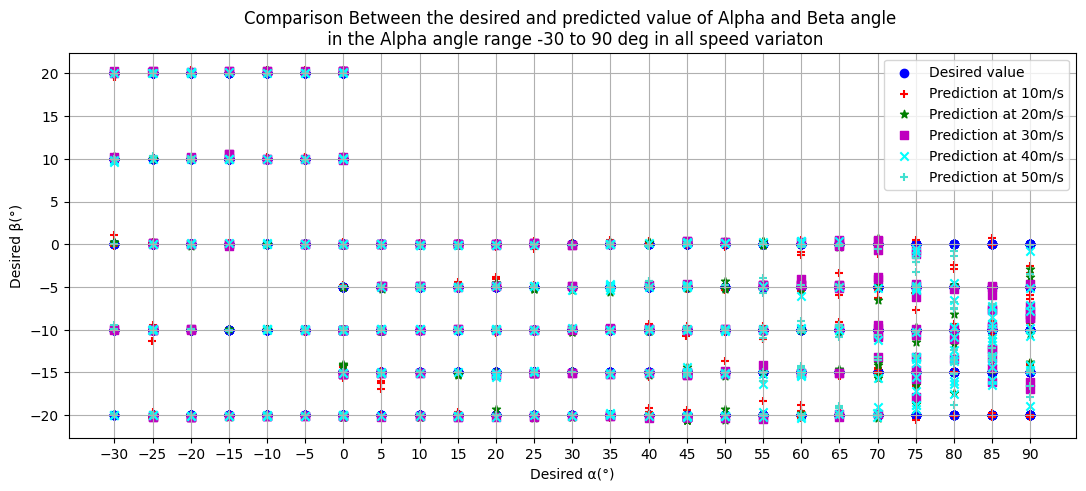

In [8]:
fig = plt.figure(figsize=(13, 5))


ax1 = fig.add_subplot()
ax1.scatter(y0_test["α"], y0_test["β"], label = 'Desired value', marker='o', color='b')
ax1.scatter(y0_pred_10["α"], y0_pred_10["β"], label = 'Prediction at 10m/s', marker='+', color='r')
ax1.scatter(y0_pred_20["α"], y0_pred_20["β"], label = 'Prediction at 20m/s', marker='*', color='green')
ax1.scatter(y0_pred_30["α"], y0_pred_30["β"], label = 'Prediction at 30m/s', marker='s', color='m')
ax1.scatter(y0_pred_40["α"], y0_pred_40["β"], label = 'Prediction at 40m/s', marker='x', color='cyan')
ax1.scatter(y0_pred_50["α"], y0_pred_50["β"], label = 'Prediction at 50m/s', marker='+', color='turquoise')
ax1.set_xlabel("Desired α(°)")
ax1.set_ylabel("Desired β(°)")
ax1.set_xticks(np.arange(-30, 95, 5))
ax1.set_yticks(np.arange(-20, 25, 5))
ax1.set_title('Comparison Between the desired and predicted value of Alpha and Beta angle \n in the Alpha angle range -30 to 90 deg in all speed variaton')
ax1.grid(True)
ax1.legend()


# plt.tight_layout()
plt.savefig('model_1_all_before_pruning.png', format='png', dpi=1000)
# Show the plot
plt.show()

In [9]:
# y_pred = [y0_pred_10, y0_pred_20, y0_pred_30, y0_pred_40, y0_pred_50]
# fig, axes = plt.subplots(5, 1, figsize=(10,30))
# speed = 10
# # Add first subplot (Alpha vs Beta)
# for i, V in enumerate(y_pred):
#     ax = axes[i]
#     ax.scatter(y0_test["α"], y0_test["β"], label = 'Desired value', marker='o', color='b')
#     ax.scatter(V["α"], V["β"], label = f'Prediction at {speed} m/s', marker='+', color='r')
#     ax.set_xlabel('Desired Alpha value (deg)')
#     ax.set_ylabel('Desired Beta value (deg)')
#     ax.set_xlabel("Desired α(°)")
#     ax.set_ylabel("Desired β(°)")
#     ax.set_title(f'Comparison Between the desired and predicted value of Alpha and Beta angle \n in the Alpha angle range -30 to 90 deg for {speed} m/s')
#     ax.grid(True)
#     speed += 10
    
# plt.savefig('model_1_every_before_pruning.png', format='png', dpi=1500)
# plt.tight_layout()
# plt.show()

0.07518822644199474 561 
 V              10.057256
α              75.000000
β               0.000000
alpha_error     0.075188
Name: 561, dtype: float64
0.05254849329476485 3684 
 V              20.060925
α              85.000000
β             -15.000000
alpha_error     0.052548
Name: 3684, dtype: float64
0.027254742183188796 730 
 V              30.011934
α              60.000000
β               0.000000
alpha_error     0.027255
Name: 730, dtype: float64
0.02271428951100063 4857 
 V              40.035536
α              70.000000
β             -20.000000
alpha_error     0.022714
Name: 4857, dtype: float64
0.030687250943580935 6020 
 V              50.054263
α             -10.000000
β               0.000000
alpha_error     0.030687
Name: 6020, dtype: float64


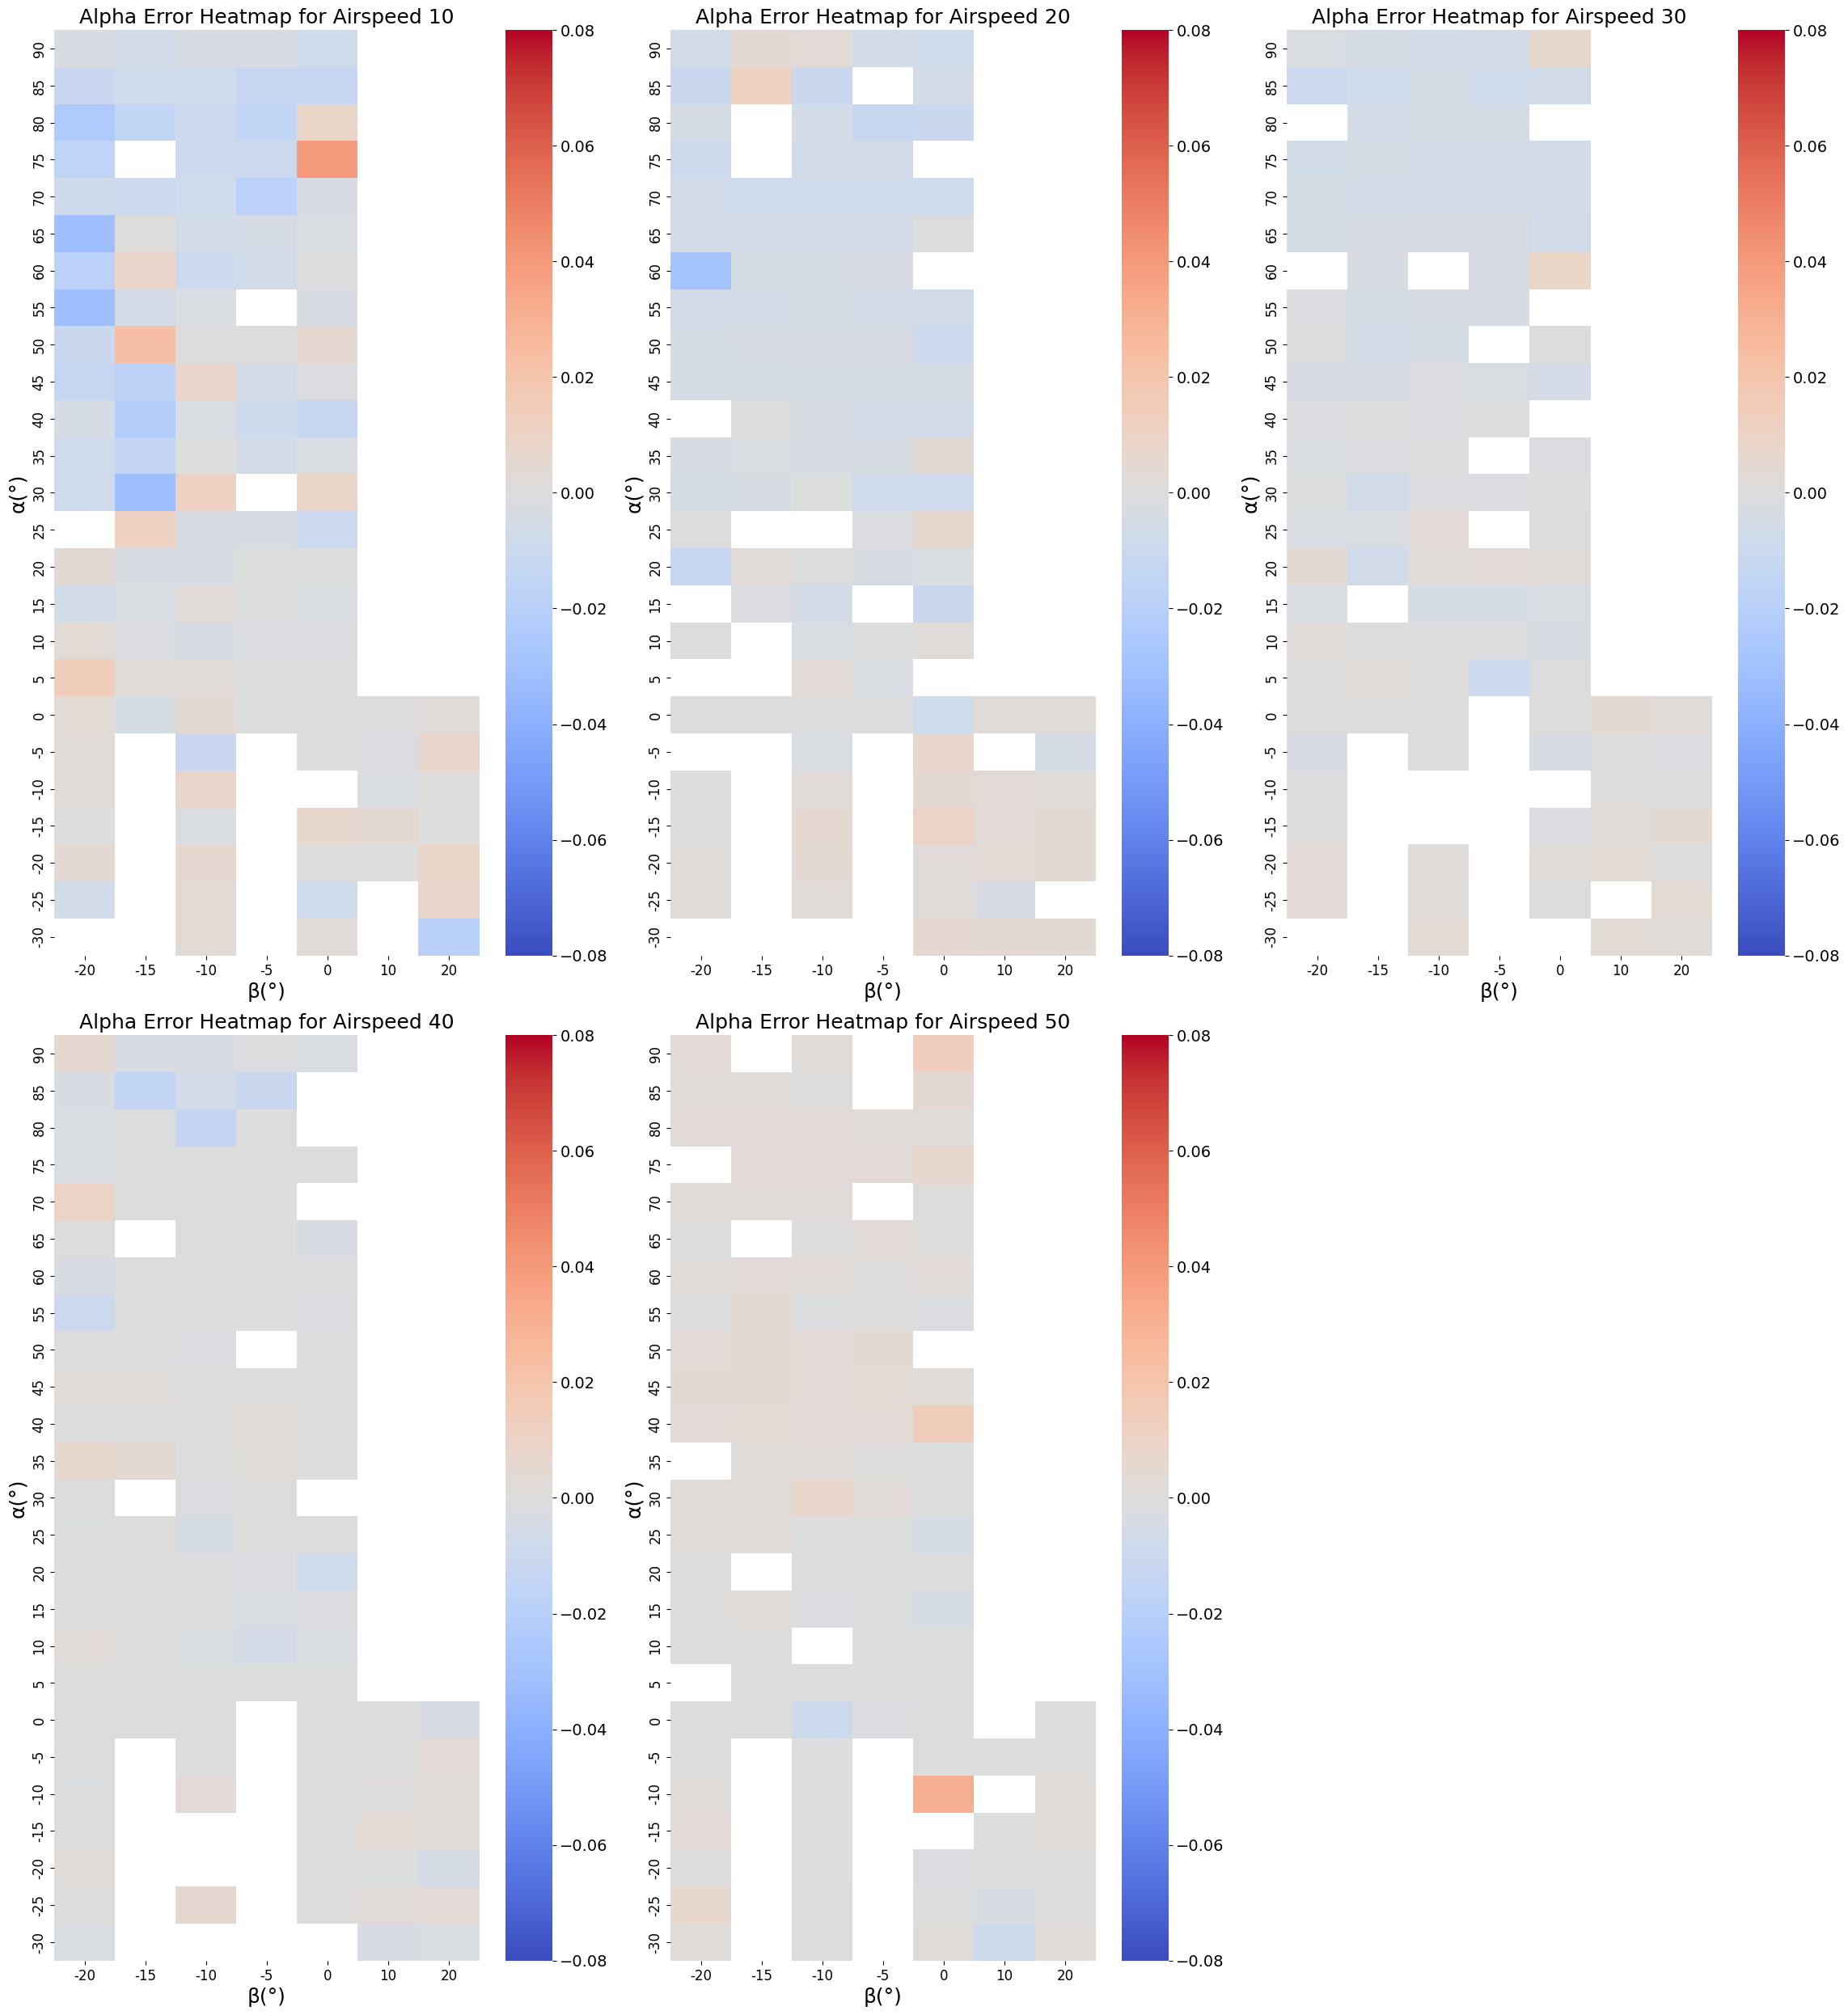

In [10]:
pred_result = [y0_pred_10, y0_pred_20, y0_pred_30, y0_pred_40, y0_pred_50]
act_result = [y0_test_10, y0_test_20, y0_test_30, y0_test_40, y0_test_50]

fig, axes = plt.subplots(2, 3, figsize=(23, 25))
axes = axes.flatten()
for i in range(len(pred_result)):
    actual = act_result[i].copy()
    alpha_values_pred = pred_result[i]["α"]
    beta_values_pred = pred_result[i]["β"]
    alpha_values_act = act_result[i]["α"]
    beta_values_act = act_result[i]["β"]
    actual['alpha_error'] = alpha_values_act - alpha_values_pred
    print(actual['alpha_error'].max(), actual['alpha_error'].idxmax(), '\n', actual.loc[actual['alpha_error'].idxmax()] )
    actual['beta_error'] = beta_values_act - beta_values_pred
    ax = axes[i]
    pivot_table = actual.pivot_table(index='α', columns='β', values='alpha_error')
    heatmap = sns.heatmap(
        pivot_table,
        cmap='coolwarm',
        ax = axes [i],
        vmin = -0.08,
        vmax = 0.08
    )
    ax.set_title(f'Alpha Error Heatmap for Airspeed {10+i*10}', fontsize = 18)
    ax.set_xlabel("β(°)",fontsize = 18)
    ax.set_ylabel("α(°)", fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.invert_yaxis()
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
for j in range(len(pred_result), len(axes)):
    axes[j].axis('off')
plt.savefig('model_1_heatmap_alpha_before_pruning.png', format='png', dpi=1200, bbox_inches='tight')
plt.tight_layout(pad=1.0) 
plt.show()

5.916014378229729 598 
 V              10.029069
α              90.000000
β               0.000000
alpha_error    -0.008695
beta_error      5.916014
Name: 598, dtype: float64
8.872661727708255 1699 
 V              20.049202
α              90.000000
β              -5.000000
alpha_error    -0.006489
beta_error      8.872662
Name: 1699, dtype: float64
12.264704166322531 783 
 V              30.024409
α              85.000000
β               0.000000
alpha_error    -0.006848
beta_error     12.264704
Name: 783, dtype: float64
8.082731398758103 1886 
 V              40.037530
α              85.000000
β              -5.000000
alpha_error    -0.028826
beta_error      8.082731
Name: 1886, dtype: float64
12.19396973582084 982 
 V              50.031069
α              85.000000
β               0.000000
alpha_error     0.004453
beta_error     12.193970
Name: 982, dtype: float64


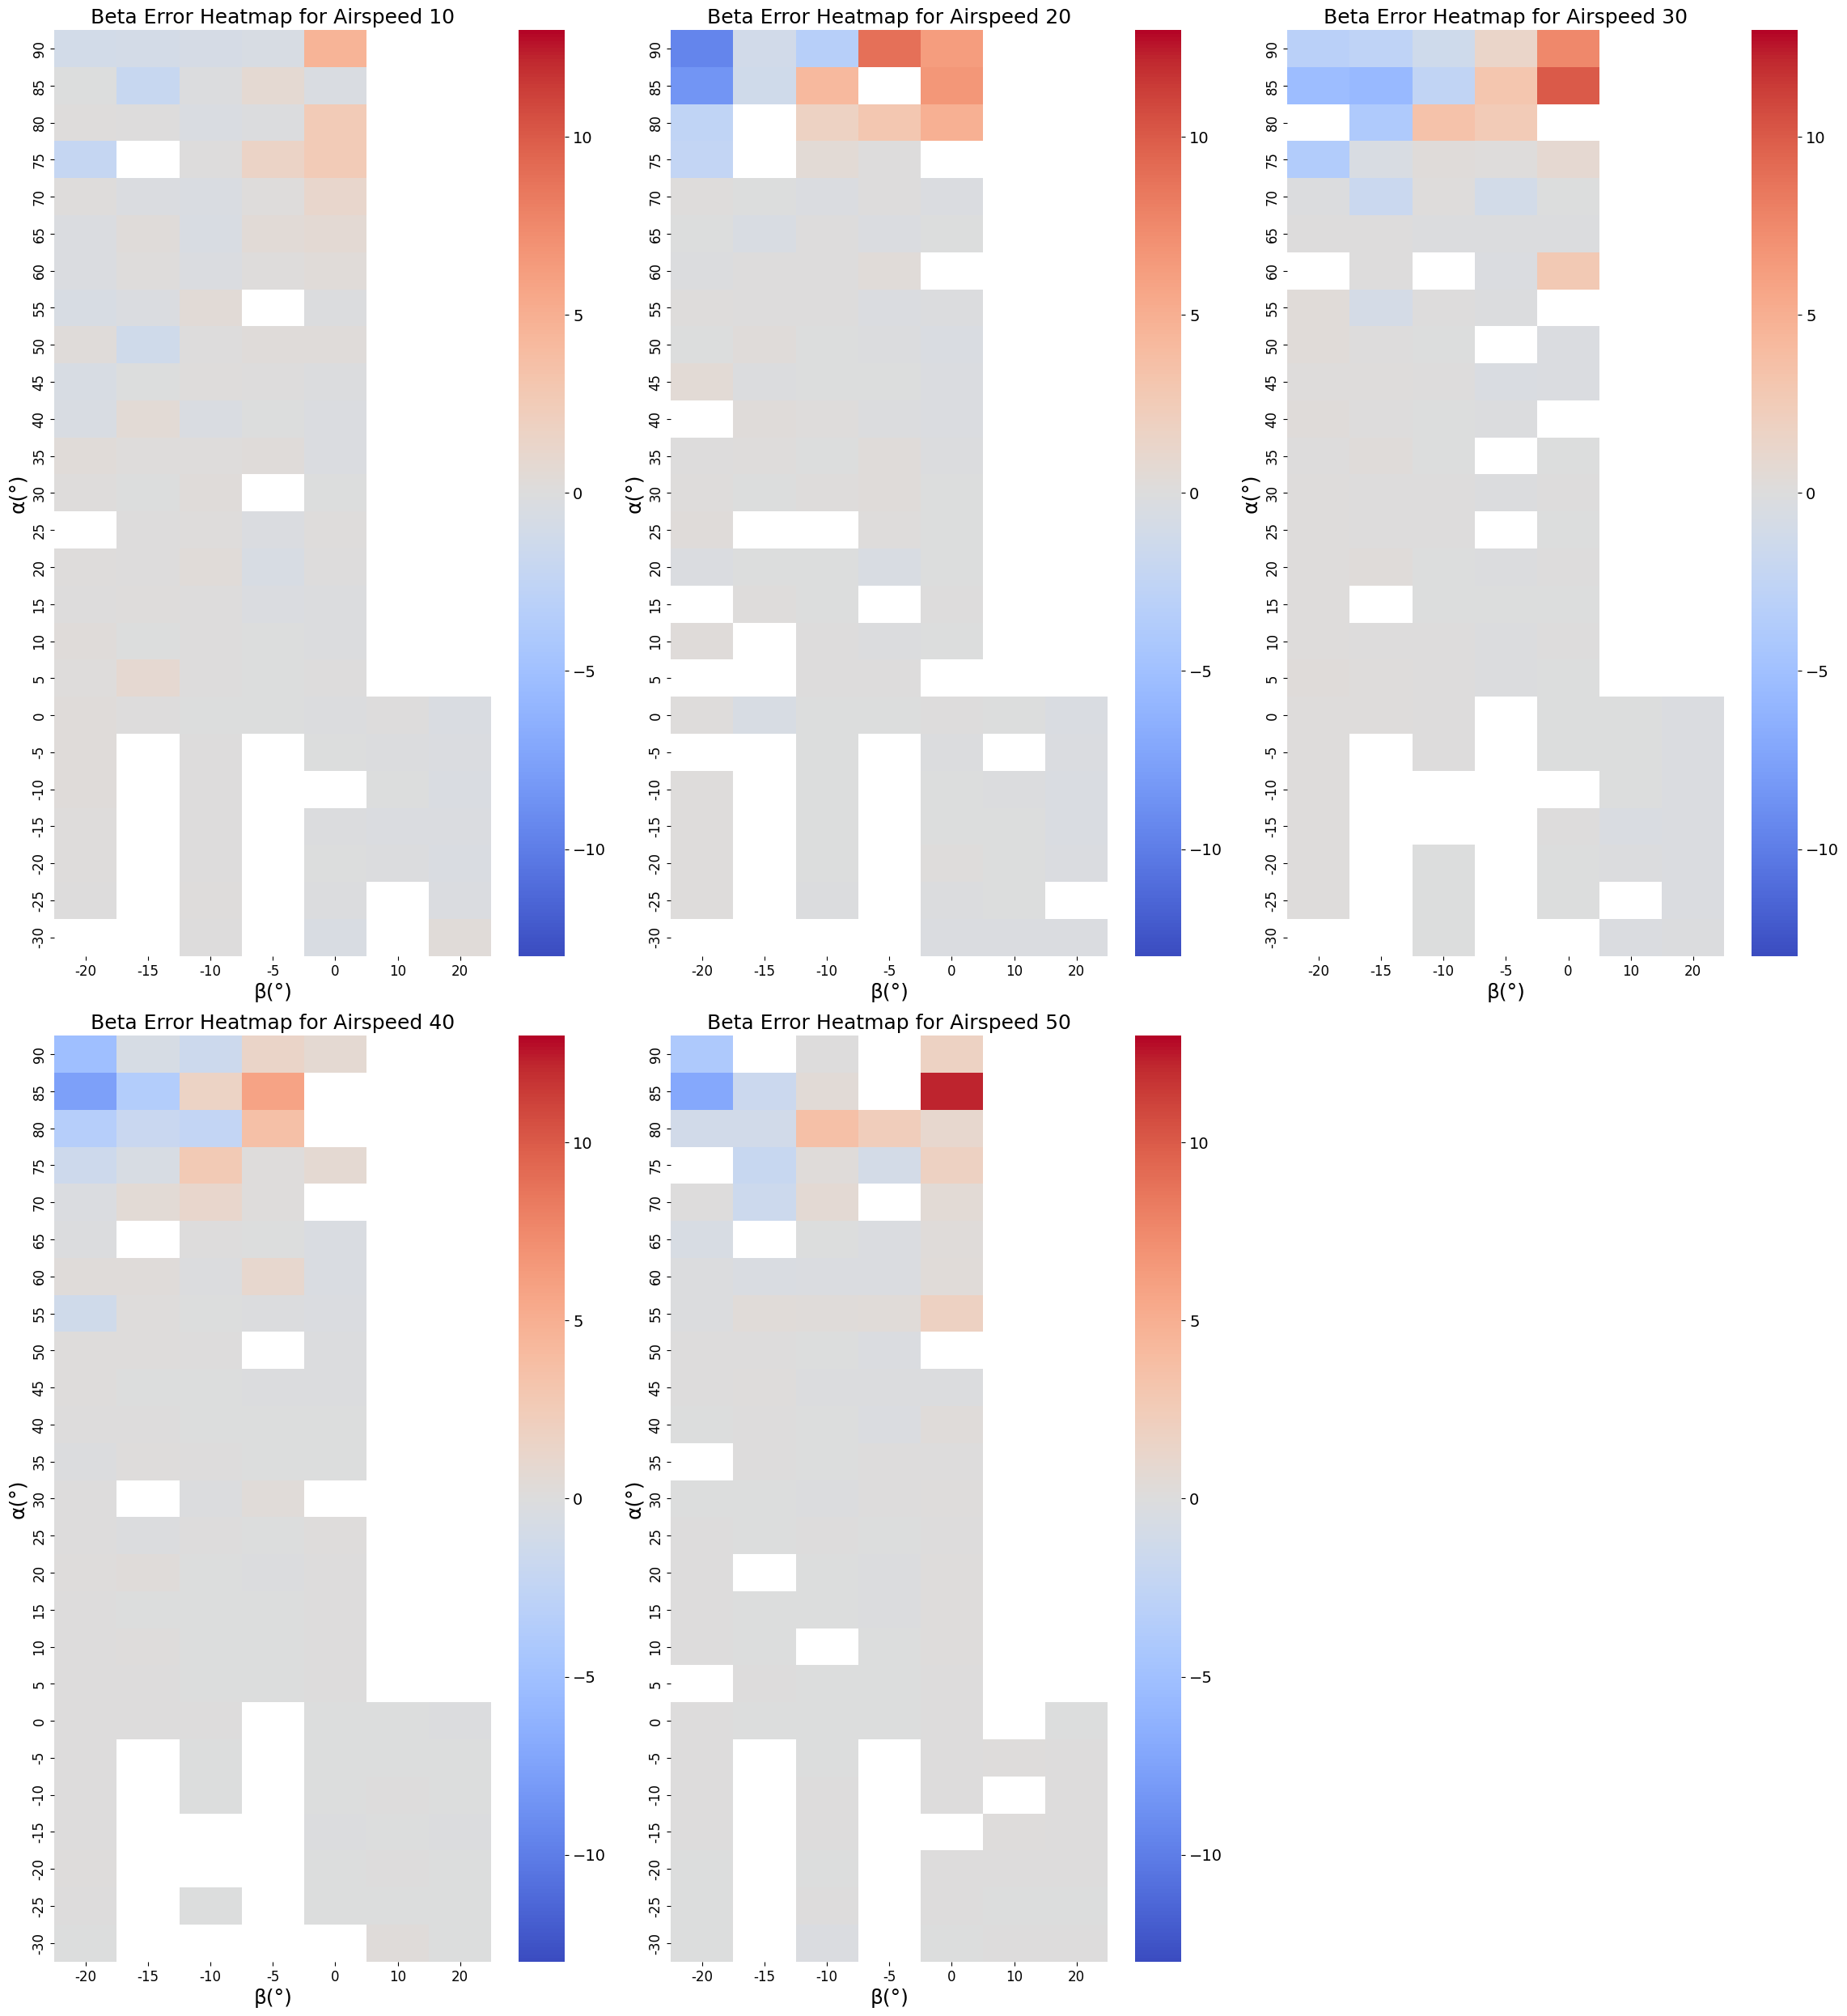

In [11]:
pred_result = [y0_pred_10, y0_pred_20, y0_pred_30, y0_pred_40, y0_pred_50]
act_result = [y0_test_10, y0_test_20, y0_test_30, y0_test_40, y0_test_50]

fig, axes = plt.subplots(2, 3, figsize=(23, 25))
axes = axes.flatten()
for i in range(len(pred_result)):
    actual = act_result[i].copy()
    alpha_values_pred = pred_result[i]["α"]
    beta_values_pred = pred_result[i]["β"]
    alpha_values_act = act_result[i]["α"]
    beta_values_act = act_result[i]["β"]
    actual['alpha_error'] = alpha_values_act - alpha_values_pred
    actual['beta_error'] = beta_values_act - beta_values_pred
    print(actual['beta_error'].max(), actual['beta_error'].idxmax(), '\n', actual.loc[actual['beta_error'].idxmax()] )
    ax = axes[i]
    pivot_table = actual.pivot_table(index='α', columns='β', values='beta_error')
    heatmap = sns.heatmap(
        pivot_table,
        cmap='coolwarm',
        ax = axes [i],
        vmin = -13,
        vmax = 13
    )
    ax.set_title(f'Beta Error Heatmap for Airspeed {10+i*10}', fontsize = 18)
    ax.set_xlabel("β(°)",fontsize = 18)
    ax.set_ylabel("α(°)", fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.invert_yaxis()
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
for j in range(len(pred_result), len(axes)):
    axes[j].axis('off')
plt.savefig('model_1_heatmap_beta_before_pruning.png', format='png', dpi=1200, bbox_inches='tight')
plt.tight_layout(pad=1.0) 
plt.show()
# pred_result = [y0_pred_10, y0_pred_20, y0_pred_30, y0_pred_40, y0_pred_50]
# act_result = [y0_test_10, y0_test_20, y0_test_30, y0_test_40, y0_test_50]

# fig, axes = plt.subplots(2, 3, figsize=(20, 15))
# axes = axes.flatten()
# for i in range(len(pred_result)):
#     actual = act_result[i].copy()
#     alpha_values_pred = pred_result[i]["α"]
#     beta_values_pred = pred_result[i]["β"]
#     alpha_values_act = act_result[i]["α"]
#     beta_values_act = act_result[i]["β"]
#     actual['alpha_error'] = alpha_values_act - alpha_values_pred
#     actual['beta_error'] = beta_values_act - beta_values_pred
#     ax = axes[i]
#     pivot_table = actual.pivot_table(index='α', columns='β', values='beta_error')
#     sns.heatmap(
#         pivot_table,
#         cmap='coolwarm',
#         ax = axes [i],
#     )
#     ax.set_title(f'Beta Error Heatmap for Airspeed {10+i*10}')
#     ax.set_xlabel("β(°)")
#     ax.set_ylabel("α(°)")
#     ax.invert_yaxis()
# for j in range(len(pred_result), len(axes)):
#     axes[j].axis('off')
# plt.savefig('model_1_heatmap_beta_before_pruning.png', format='png', dpi=1500)
# plt.tight_layout(rect=[0, 0, 0.9, 1]) 
# plt.show()

## AFTER PRUNING

In [96]:
df_all = pd.read_csv('data_clean_reduce_24.csv')
x_all = df_all.drop(columns = ["V","α","β"])
y_all = df_all[["V","α","β"]]

x0_train, x0_test, y0_train, y0_test = train_test_split(x_all, y_all,
                                                        random_state = 42, test_size = 0.2)

In [97]:
def max_absolute_error(y_true, y_pred):
    return np.max(np.abs(y_true - y_pred), axis=0)
scaler = StandardScaler()

# Base models (Level Pertama)
base_models = [
    ('random_forest', RandomForestRegressor(n_estimators=250, max_depth=None, random_state=42, min_samples_leaf= 1, min_samples_split= 2, max_features = 'sqrt')),
    ('gradient_boosting', GradientBoostingRegressor(n_estimators=200, learning_rate=0.0579, random_state=42, max_depth = 5)),
    ('knn', make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=2, weights='distance', algorithm='auto')))
]

# Meta-model (Level Kedua)
# Menggunakan Ridge Regression sebagai meta-model untuk menghindari overfitting
meta_model = Ridge(alpha=0.1)

# Membentuk Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True  # Memasukkan data asli ke meta-model bersama prediksi base models
)

# Untuk multi-output, kita bungkus dengan MultiOutputRegressor
model_all_best = MultiOutputRegressor(stacking_regressor)
start = time.time()
# Training
model_all_best.fit(x0_train, y0_train)
end = time.time()
waktu = (end-start)/60
# Prediction
y0_pred = model_all_best.predict(x0_test)
r2 = r2_score(y0_test, y0_pred, multioutput = 'raw_values')
mae = mean_absolute_error(y0_test, y0_pred, multioutput = 'raw_values')
mse = mean_squared_error(y0_test, y0_pred, multioutput = 'raw_values')
max_ae = max_absolute_error(y0_test, y0_pred)
print(f'R2 : \n Alpha : {r2[1]} \n Beta : {r2[2]} \n V : {r2[0]} ')
print(f'MAE : \n Alpha : {mae[1]} \n Beta : {mae[2]} \n V : {mae[0]} ')
print(f'MSE : \n Alpha : {mse[1]} \n Beta : {mse[2]} \n V : {mse[0]} ')
print('Max AERR : \n', max_ae)
print("Waktu yang dibutuhkan : ", waktu)

R2 : 
 Alpha : 0.9999999888364483 
 Beta : 0.9855572270835813 
 V : 0.9999998576576354 
MAE : 
 Alpha : 0.0018578545045363193 
 Beta : 0.4649694558260702 
 V : 0.0014418516960277908 
MSE : 
 Alpha : 1.2746920367403166e-05 
 Beta : 1.5371880960149589 
 V : 2.9044107812892754e-05 
Max AERR : 
 V     0.050330
α     0.048791
β    10.644980
dtype: float64
Waktu yang dibutuhkan :  1.4418482939402262


In [98]:
y_cv_pred = cross_val_predict(model_all_best, x0_train, y0_train, cv=5)
print ('R2 V CV : ',(r2_score(y0_train['V'], y_cv_pred[:,0])))
print ('R2 Alpha CV : ',(r2_score(y0_train['α'], y_cv_pred[:,1])))
print ('R2 Beta CV : ',(r2_score(y0_train['β'], y_cv_pred[:,2])))
print ('R2 V Test : ',(r2_score(y0_test['V'], y0_pred[:,0])))
print ('R2 Alpha Test : ',(r2_score(y0_test['α'], y0_pred[:,1])))
print ('R2 Beta CV : ',(r2_score(y0_test['β'], y0_pred[:,2])))
print('MAE V CV : ', (mean_absolute_error(y0_train['V'], y_cv_pred[:,0])))
print('MAE Alpha CV : ', (mean_absolute_error(y0_train['α'], y_cv_pred[:,1])))
print('MAE Beta CV : ', (mean_absolute_error(y0_train['β'], y_cv_pred[:,2])))
print('MAE V Test : ', (mean_absolute_error(y0_test['V'], y0_pred[:,0])))
print('MAE Alpha Test : ', (mean_absolute_error(y0_test['α'], y0_pred[:,1])))
print('MAE Beta Test : ', (mean_absolute_error(y0_test['β'], y0_pred[:,2])))

R2 V CV :  0.999999675827159
R2 Alpha CV :  0.9999964011554513
R2 Beta CV :  0.977219037321876
R2 V Test :  0.9999998576576354
R2 Alpha Test :  0.9999999888364483
R2 Beta CV :  0.9855572270835813
MAE V CV :  0.0021075139047423814
MAE Alpha CV :  0.011326069991429325
MAE Beta CV :  0.6141859900194605
MAE V Test :  0.0014418516960277908
MAE Alpha Test :  0.0018578545045363193
MAE Beta Test :  0.4649694558260702


In [99]:
scoring = {
    'r2': 'r2',
    'mae': make_scorer(mean_absolute_error, greater_is_better=False),      
}
cv_scores = cross_validate(model_all_best, x0_train, y0_train, cv=5, scoring=scoring)

print("Cross-Validation R² Scores:", cv_scores['test_r2'])
print("Mean CV R² Score:", cv_scores['test_r2'].mean())

print("Cross-Validation MAE Scores:", -cv_scores['test_mae'])  
print("Mean CV MAE Score:", -cv_scores['test_mae'].mean())

test_score_r2 = model_all_best.score(x0_test, y0_test)
test_score_mae = mean_absolute_error(y0_test, y0_pred)
print("Test R² Score:", test_score_r2)
print(f"Test MAE: {test_score_mae:.6f}")

Cross-Validation R² Scores: [0.99112996 0.99346548 0.99216934 0.99246847 0.99278891]
Mean CV R² Score: 0.9924044311290947
Cross-Validation MAE Scores: [0.23007989 0.18466079 0.20741577 0.2072905  0.21658567]
Mean CV MAE Score: 0.20920652463854408
Test R² Score: 0.995185691192555
Test MAE: 0.156090


In [100]:
y0_train_pred = model_all_best.predict(x0_train)
r2_train = r2_score(y0_train, y0_train_pred, multioutput = 'raw_values')
mae_train = mean_absolute_error(y0_train, y0_train_pred, multioutput = 'raw_values')
mse_train = mean_squared_error(y0_train, y0_train_pred, multioutput = 'raw_values')
max_ae_train = max_absolute_error(y0_train, y0_train_pred)
print(f'R2 : \n Alpha : {r2_train[1]} \n Beta : {r2_train[2]} \n V : {r2_train[0]} ')
print(f'MAE : \n Alpha : {mae_train[1]} \n Beta : {mae_train[2]} \n V : {mae_train[0]} ')
print(f'MSE : \n Alpha : {mse_train[1]} \n Beta : {mse_train[2]} \n V : {mse_train[0]} ')
print('Max AERR : \n', max_ae_train)

R2 : 
 Alpha : 0.9999999973137625 
 Beta : 0.998875299097437 
 V : 0.999999998257017 
MAE : 
 Alpha : 0.0013427178155107917 
 Beta : 0.20468556942818852 
 V : 0.00036442429690614406 
MSE : 
 Alpha : 3.388503603089018e-06 
 Beta : 0.12204186054380935 
 V : 3.470107608327521e-07 
Max AERR : 
 V    0.006041
α    0.016096
β    3.181380
dtype: float64


In [14]:
y_pred_df = pd.DataFrame(y0_pred, columns = ["V","α","β"], index = y0_test.index)
y0_pred_10 = y_pred_df[(y_pred_df["V"] >= 8.5) & (y_pred_df["V"] <= 11.5)]
y0_pred_20 = y_pred_df[(y_pred_df["V"] >= 18.5) & (y_pred_df["V"] <= 21.5)]
y0_pred_30 = y_pred_df[(y_pred_df["V"] >= 28.5) & (y_pred_df["V"] <= 31.5)]
y0_pred_40 = y_pred_df[(y_pred_df["V"] >= 38.5) & (y_pred_df["V"] <= 41.5)]
y0_pred_50 = y_pred_df[(y_pred_df["V"] >= 48.5) & (y_pred_df["V"] <= 51.5)]

In [15]:
y0_test_10 = y0_test[(y0_test['V'] >= 8.5) & (y0_test['V'] <= 11.5)]
y0_test_20 = y0_test[(y0_test['V'] >= 18.5) & (y0_test['V'] <= 21.5)]
y0_test_30 = y0_test[(y0_test['V'] >= 28.5) & (y0_test['V'] <= 31.5)]
y0_test_40 = y0_test[(y0_test['V'] >= 38.5) & (y0_test['V'] <= 41.5)]
y0_test_50 = y0_test[(y0_test['V'] >= 48.5) & (y0_test['V'] <= 51.5)]

In [16]:
print(len(y0_test_10), len(y0_pred_10))
print(len(y0_test_20), len(y0_pred_20))
print(len(y0_test_30), len(y0_pred_30))
print(len(y0_test_40), len(y0_pred_40))
print(len(y0_test_50), len(y0_pred_50))
test = len(y0_test_10) + len(y0_test_20) + len(y0_test_30) + len(y0_test_40) + len(y0_test_50)
predict = len(y0_pred_10) + len(y0_pred_20) + len(y0_pred_30) + len(y0_pred_40) + len(y0_pred_50)
if test == predict :
    print('True')

280 280
254 254
263 263
274 274
275 275
True


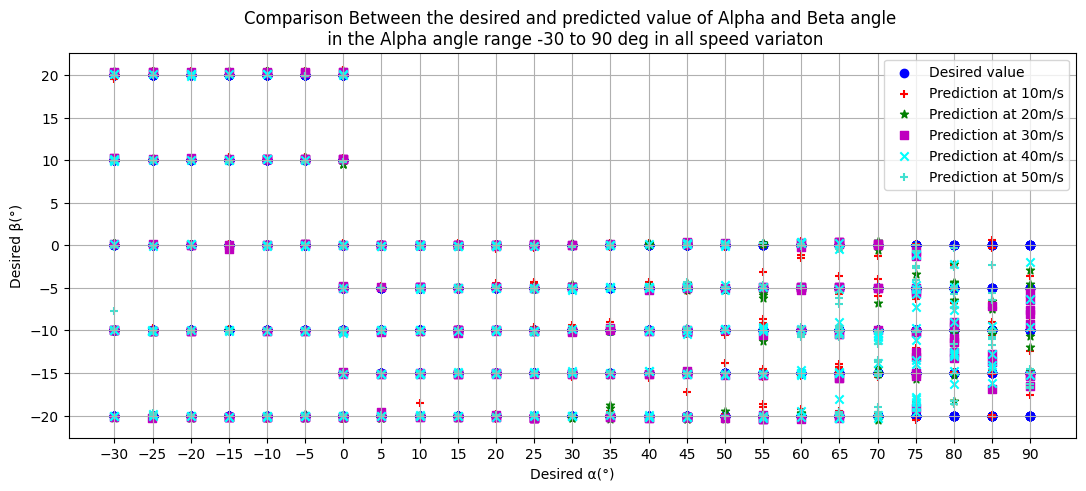

In [17]:
fig = plt.figure(figsize=(13, 5))


ax1 = fig.add_subplot()
ax1.scatter(y0_test["α"], y0_test["β"], label = 'Desired value', marker='o', color='b')
ax1.scatter(y0_pred_10["α"], y0_pred_10["β"], label = 'Prediction at 10m/s', marker='+', color='r')
ax1.scatter(y0_pred_20["α"], y0_pred_20["β"], label = 'Prediction at 20m/s', marker='*', color='green')
ax1.scatter(y0_pred_30["α"], y0_pred_30["β"], label = 'Prediction at 30m/s', marker='s', color='m')
ax1.scatter(y0_pred_40["α"], y0_pred_40["β"], label = 'Prediction at 40m/s', marker='x', color='cyan')
ax1.scatter(y0_pred_50["α"], y0_pred_50["β"], label = 'Prediction at 50m/s', marker='+', color='turquoise')
ax1.set_xlabel("Desired α(°)")
ax1.set_ylabel("Desired β(°)")
ax1.set_xticks(np.arange(-30, 95, 5))
ax1.set_yticks(np.arange(-20, 25, 5))
ax1.set_title('Comparison Between the desired and predicted value of Alpha and Beta angle \n in the Alpha angle range -30 to 90 deg in all speed variaton')
ax1.grid(True)
ax1.legend()

plt.savefig('model_1_all_after_pruning.png', format='png', dpi=1000)
plt.show()

In [18]:
# y_pred = [y0_pred_10, y0_pred_20, y0_pred_30, y0_pred_40, y0_pred_50]
# fig, axes = plt.subplots(5, 1, figsize=(10,30))
# speed = 10
# # Add first subplot (Alpha vs Beta)
# for i, V in enumerate(y_pred):
#     ax = axes[i]
#     ax.scatter(y0_test["α"], y0_test["β"], label = 'Desired value', marker='o', color='b')
#     ax.scatter(V["α"], V["β"], label = f'Prediction at {speed} m/s', marker='+', color='r')
#     ax.set_xlabel("Desired α(°)")
#     ax.set_ylabel("Desired β(°)")
#     ax.set_xticks(np.arange(-30, 95, 5))
#     ax.set_yticks(np.arange(-20, 25, 5))
#     ax.set_title(f'Comparison Between the desired and predicted value of Alpha and Beta angle \n in the Alpha angle range -30 to 90 deg for {speed} m/s')
#     ax.grid(True)
#     speed += 10
    

# plt.savefig('model_1_every_after_pruning.png', format='png', dpi=1000)
# plt.tight_layout()
# plt.show()

0.04879126096732023 2510 
 V              10.025167
α              50.000000
β             -10.000000
alpha_error     0.048791
Name: 2510, dtype: float64
0.008680893488058672 157 
 V              20.014832
α              25.000000
β               0.000000
alpha_error     0.008681
Name: 157, dtype: float64
0.011011225954973725 712 
 V              29.974361
α              50.000000
β               0.000000
alpha_error     0.011011
Name: 712, dtype: float64
0.011562558857621225 5598 
 V              40.034521
α               0.000000
β             -10.000000
alpha_error     0.011563
Name: 5598, dtype: float64
0.00829674753995846 486 
 V              50.028370
α              40.000000
β               0.000000
alpha_error     0.008297
Name: 486, dtype: float64


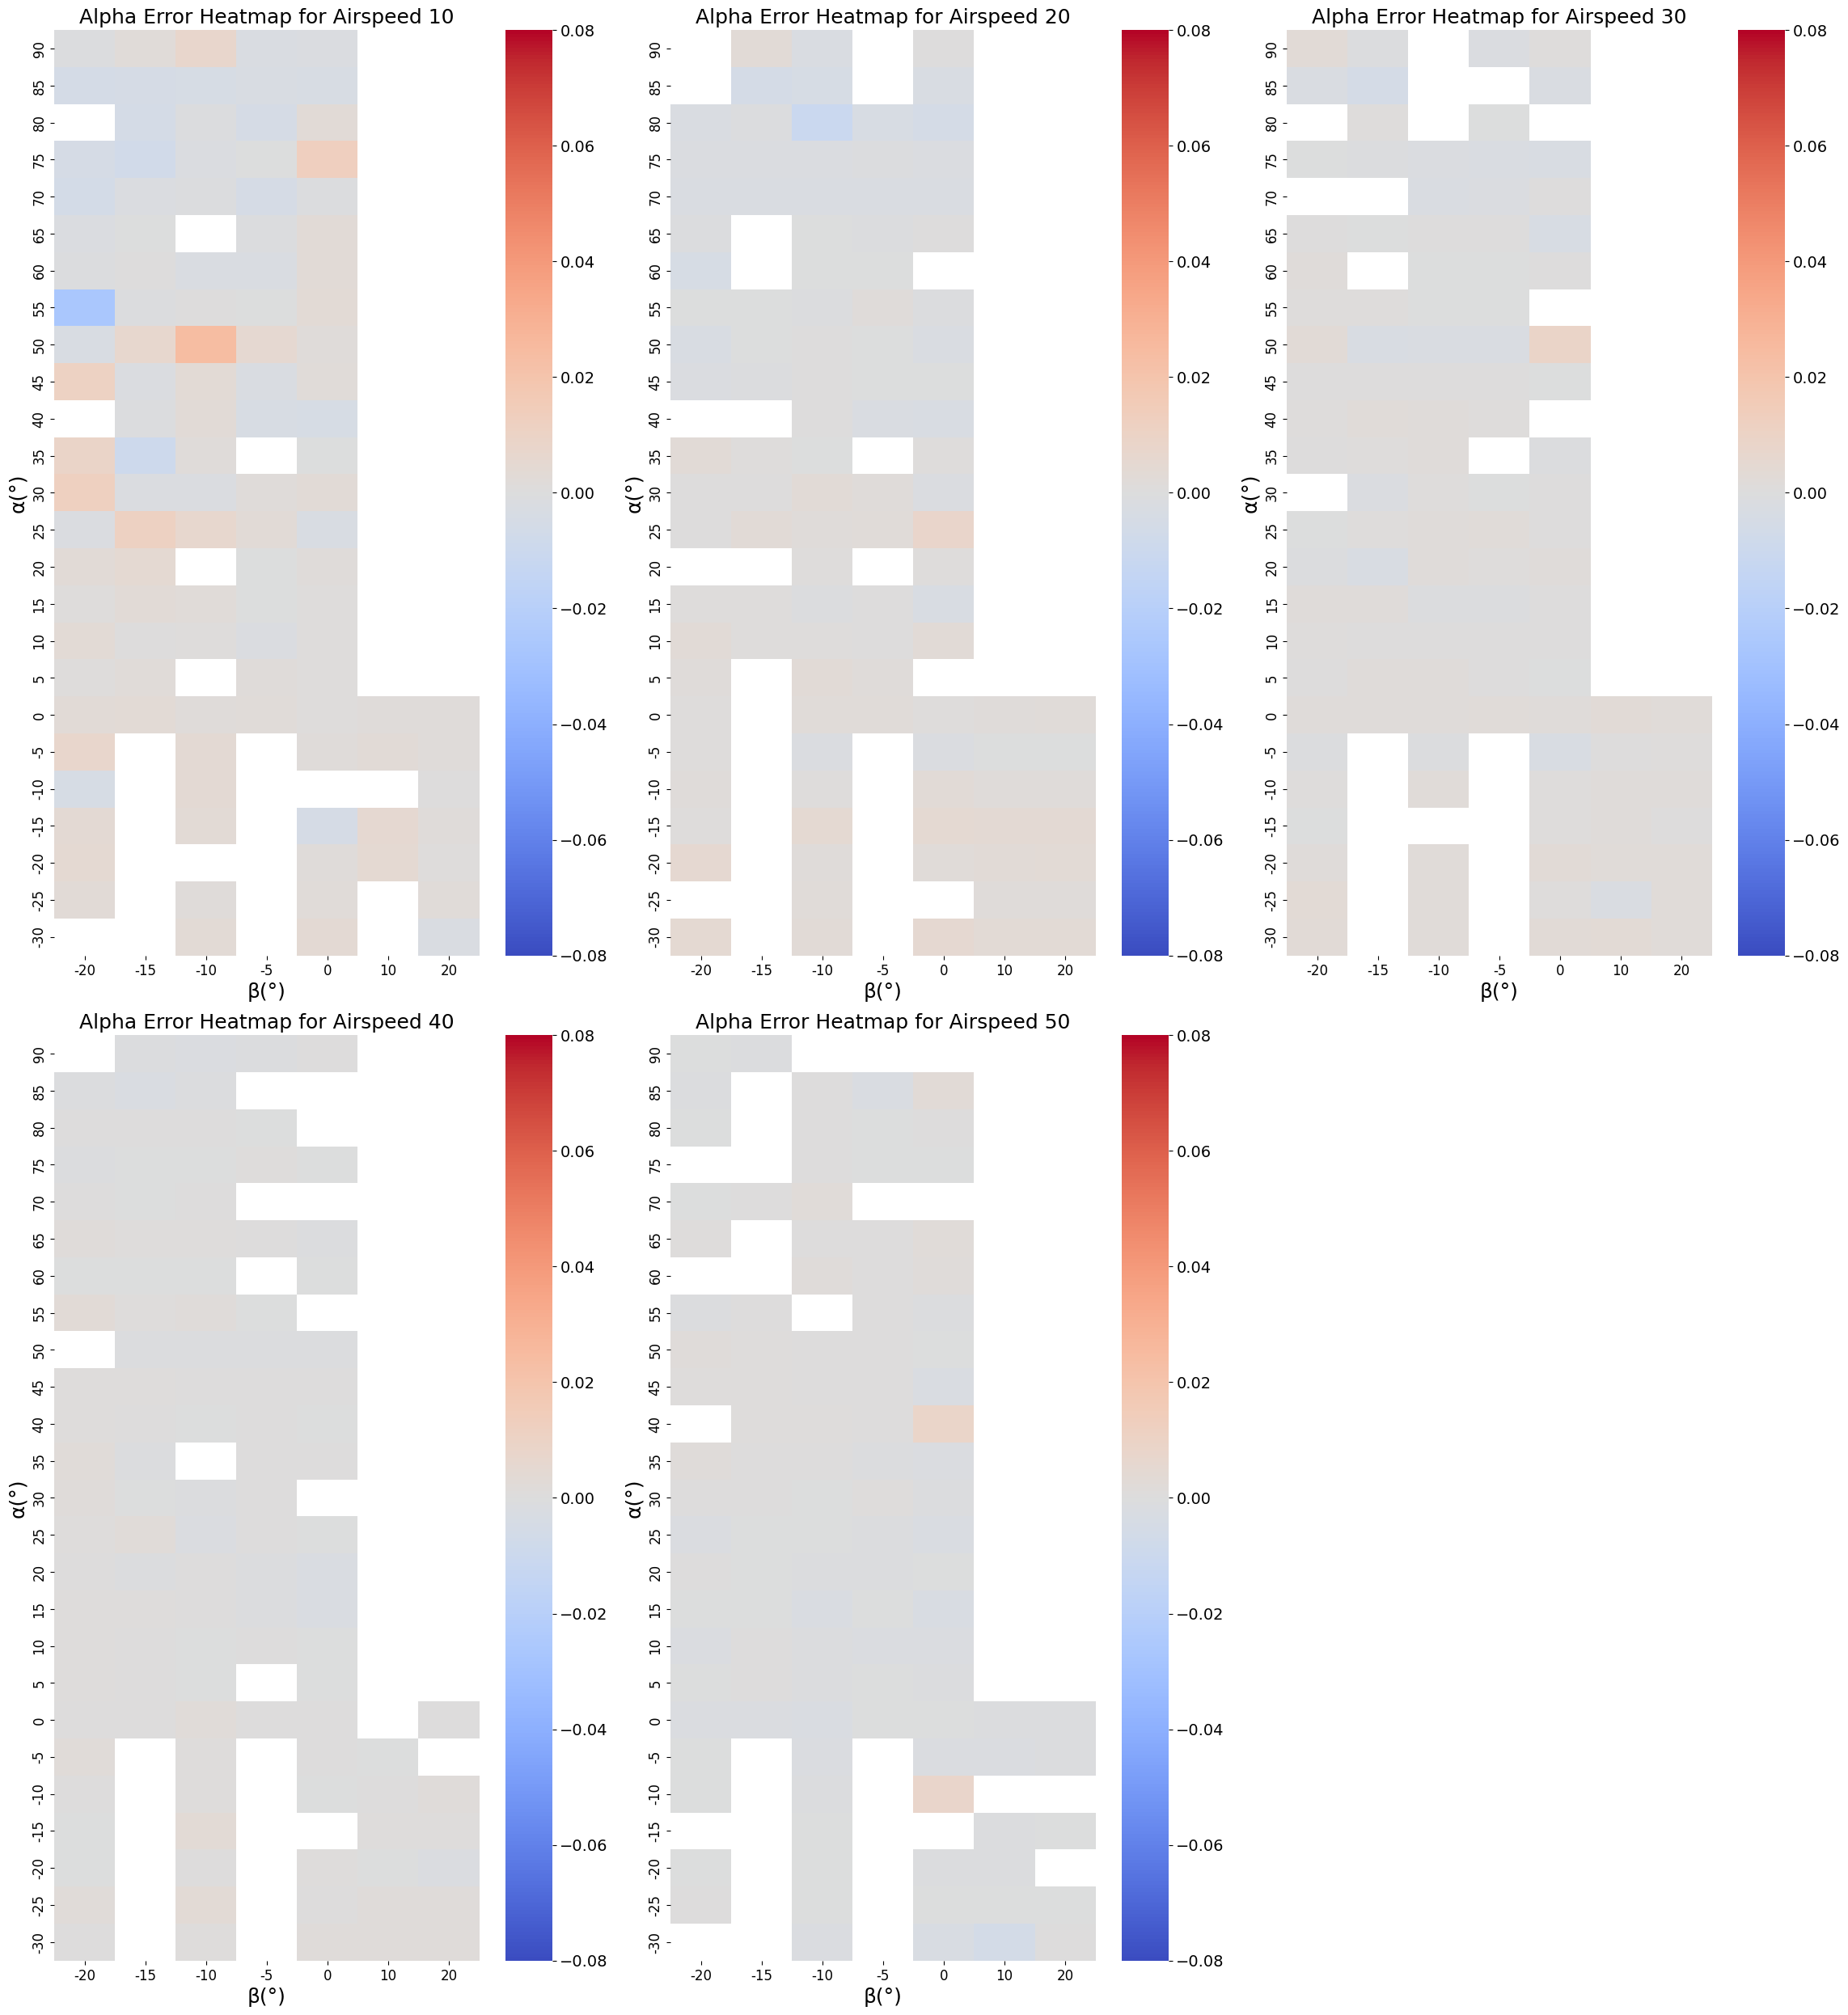

In [19]:
pred_result = [y0_pred_10, y0_pred_20, y0_pred_30, y0_pred_40, y0_pred_50]
act_result = [y0_test_10, y0_test_20, y0_test_30, y0_test_40, y0_test_50]

fig, axes = plt.subplots(2, 3, figsize=(23, 25))
axes = axes.flatten()
for i in range(len(pred_result)):
    actual = act_result[i].copy()
    alpha_values_pred = pred_result[i]["α"]
    beta_values_pred = pred_result[i]["β"]
    alpha_values_act = act_result[i]["α"]
    beta_values_act = act_result[i]["β"]
    actual['alpha_error'] = alpha_values_act - alpha_values_pred
    print(actual['alpha_error'].max(), actual['alpha_error'].idxmax(), '\n', actual.loc[actual['alpha_error'].idxmax()] )
    actual['beta_error'] = beta_values_act - beta_values_pred
    ax = axes[i]
    pivot_table = actual.pivot_table(index='α', columns='β', values='alpha_error')
    heatmap = sns.heatmap(
        pivot_table,
        cmap='coolwarm',
        ax = axes [i],
        vmin = -0.08,
        vmax = 0.08
    )
    ax.set_title(f'Alpha Error Heatmap for Airspeed {10+i*10}', fontsize = 18)
    ax.set_xlabel("β(°)",fontsize = 18)
    ax.set_ylabel("α(°)", fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.invert_yaxis()
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
for j in range(len(pred_result), len(axes)):
    axes[j].axis('off')
plt.savefig('model_1_heatmap_alpha_after_pruning.png', format='png', dpi=1200, bbox_inches='tight')
plt.tight_layout(pad=1.0) 
plt.show()

6.082429313146875 598 
 V              10.029069
α              90.000000
β               0.000000
alpha_error    -0.002596
beta_error      6.082429
Name: 598, dtype: float64
10.644979535607582 696 
 V              20.019834
α              90.000000
β               0.000000
alpha_error    -0.002856
beta_error     10.644980
Name: 696, dtype: float64
7.16582006939301 783 
 V              30.024409
α              85.000000
β               0.000000
alpha_error    -0.002490
beta_error      7.165820
Name: 783, dtype: float64
2.585672998535472 1872 
 V              40.039129
α              80.000000
β              -5.000000
alpha_error     0.000182
beta_error      2.585673
Name: 1872, dtype: float64
6.391225966787504 977 
 V              50.031069
α              85.000000
β               0.000000
alpha_error     0.004080
beta_error      6.391226
Name: 977, dtype: float64


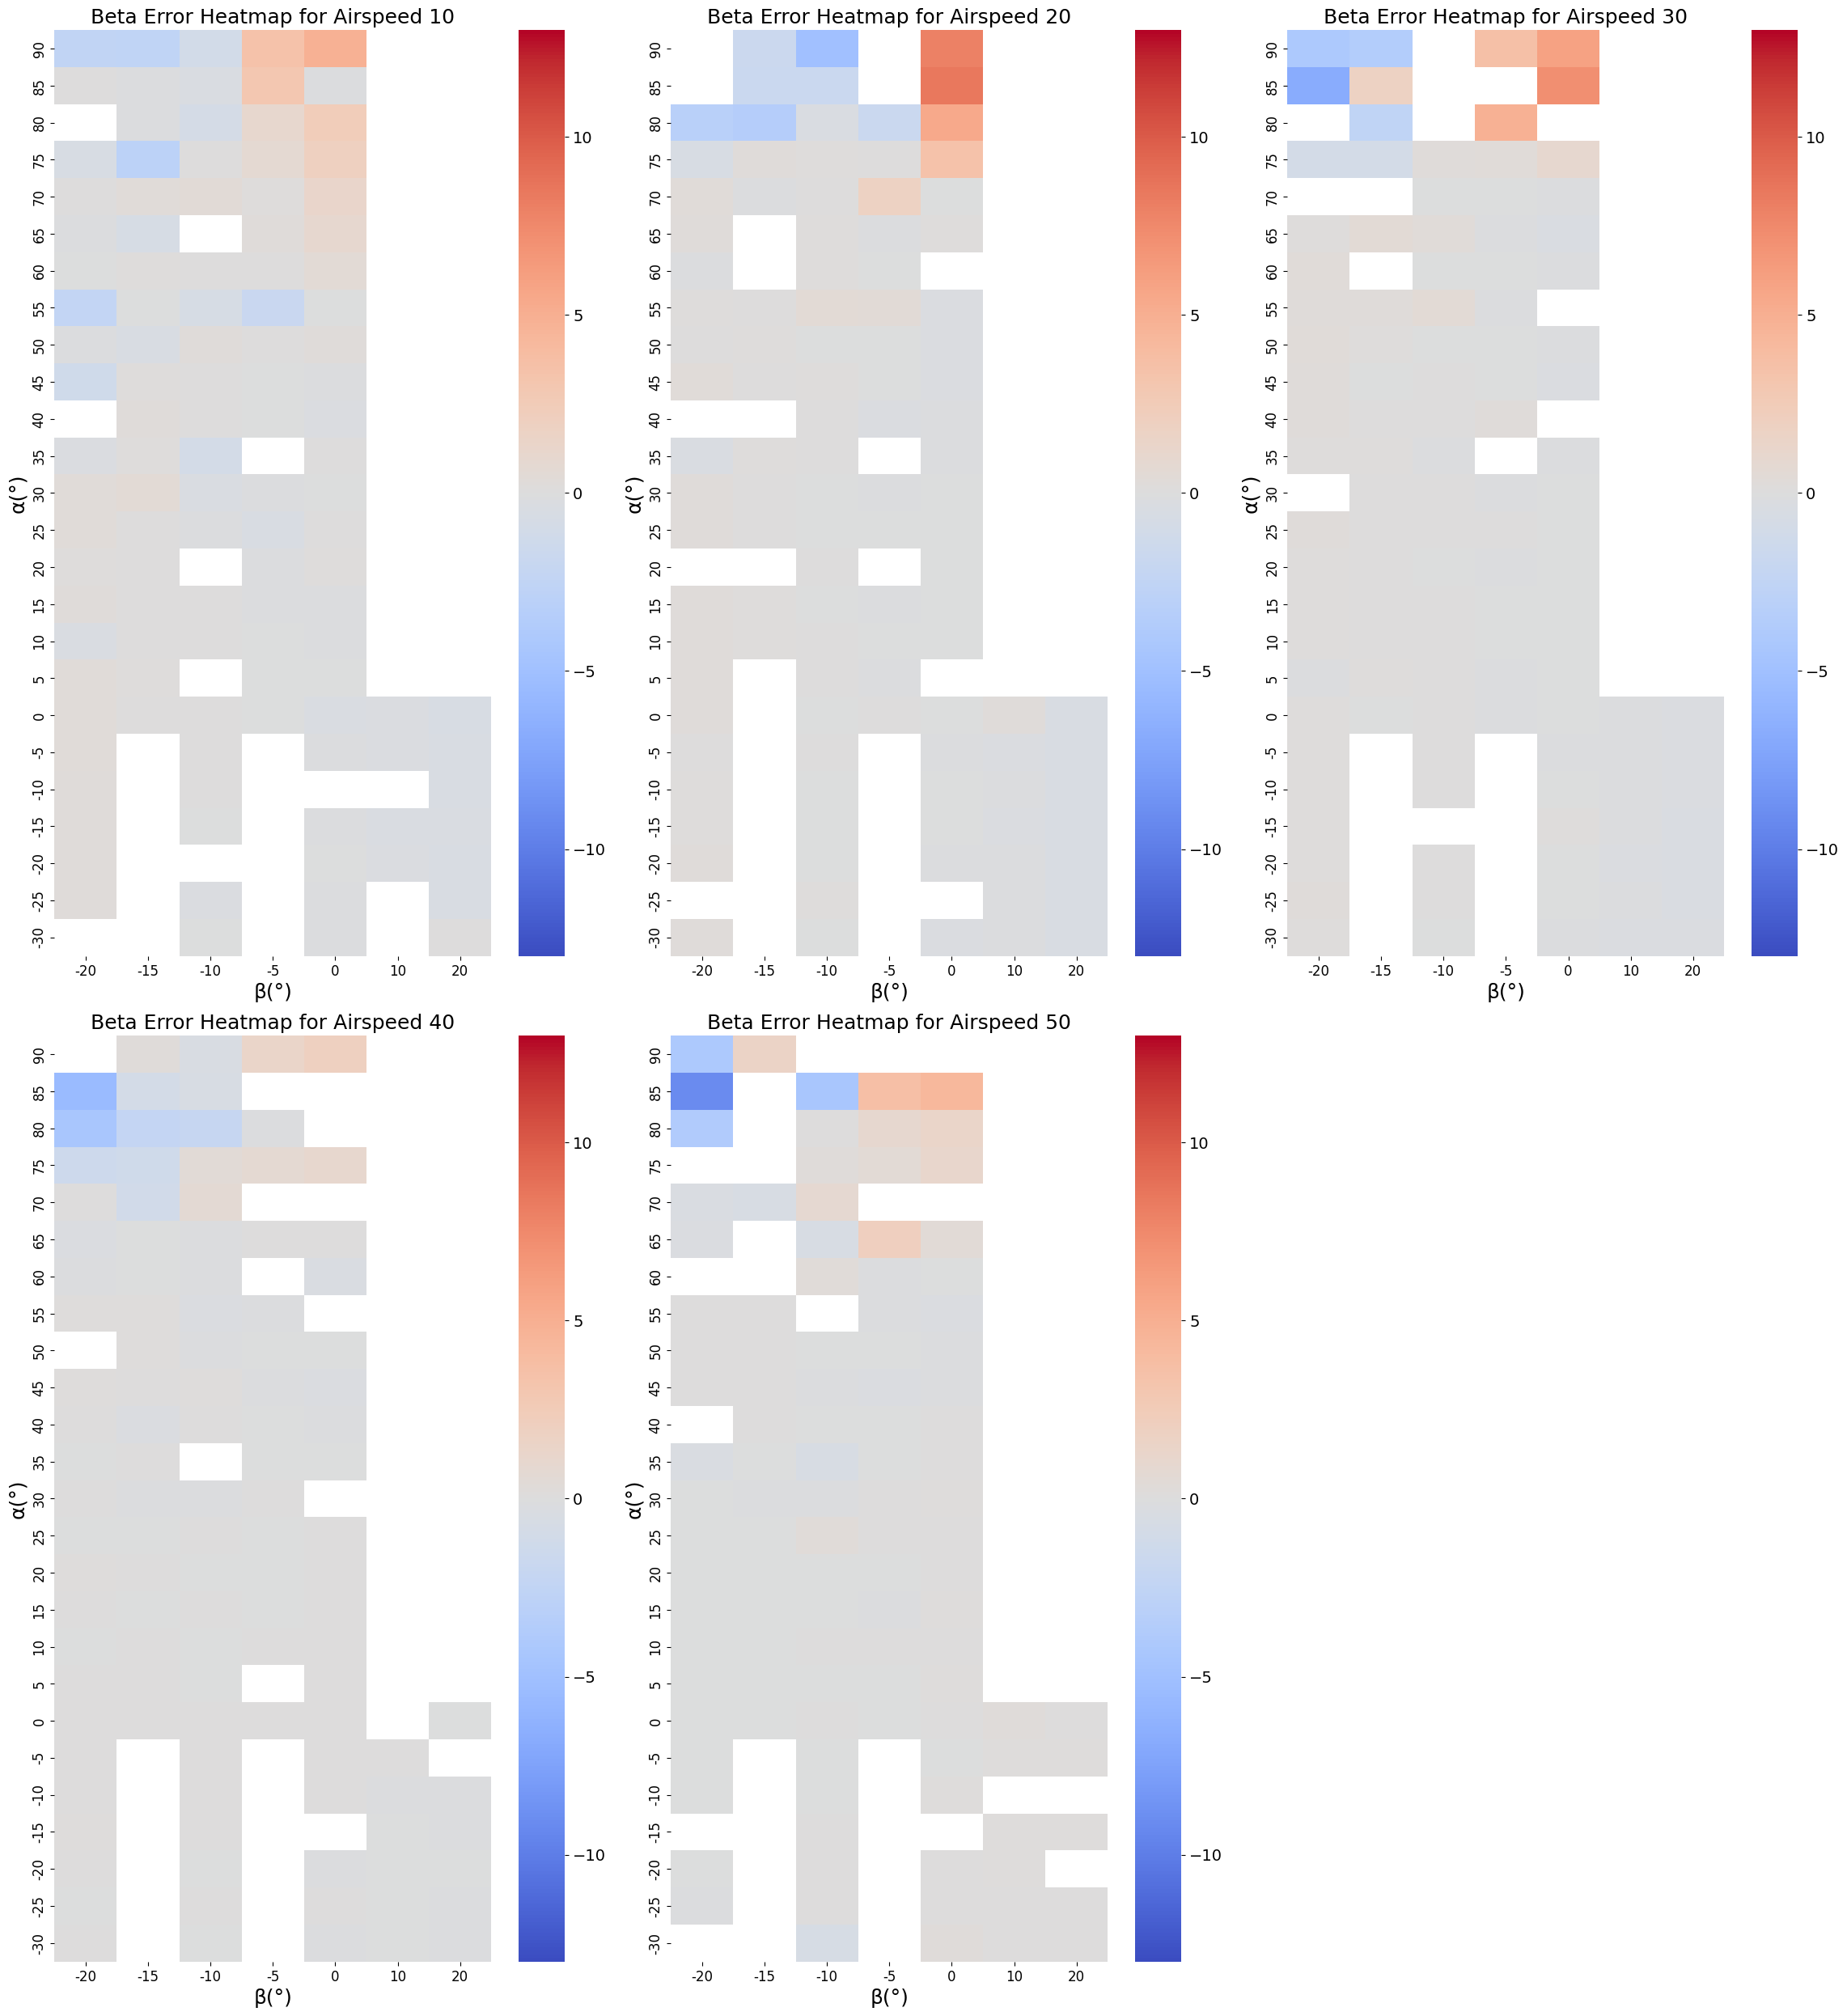

In [20]:
pred_result = [y0_pred_10, y0_pred_20, y0_pred_30, y0_pred_40, y0_pred_50]
act_result = [y0_test_10, y0_test_20, y0_test_30, y0_test_40, y0_test_50]

fig, axes = plt.subplots(2, 3, figsize=(23, 25))
axes = axes.flatten()
for i in range(len(pred_result)):
    actual = act_result[i].copy()
    alpha_values_pred = pred_result[i]["α"]
    beta_values_pred = pred_result[i]["β"]
    alpha_values_act = act_result[i]["α"]
    beta_values_act = act_result[i]["β"]
    actual['alpha_error'] = alpha_values_act - alpha_values_pred
    actual['beta_error'] = beta_values_act - beta_values_pred
    print(actual['beta_error'].max(), actual['beta_error'].idxmax(), '\n', actual.loc[actual['beta_error'].idxmax()] )
    ax = axes[i]
    pivot_table = actual.pivot_table(index='α', columns='β', values='beta_error')
    heatmap = sns.heatmap(
        pivot_table,
        cmap='coolwarm',
        ax = axes [i],
        vmin = -13,
        vmax = 13
    )
    ax.set_title(f'Beta Error Heatmap for Airspeed {10+i*10}', fontsize = 18)
    ax.set_xlabel("β(°)",fontsize = 18)
    ax.set_ylabel("α(°)", fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.invert_yaxis()
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
for j in range(len(pred_result), len(axes)):
    axes[j].axis('off')
plt.savefig('model_1_heatmap_beta_after_pruning.png', format='png', dpi=1200, bbox_inches='tight')
plt.tight_layout(pad=1.0) 
plt.show()
# pred_result = [y0_pred_10, y0_pred_20, y0_pred_30, y0_pred_40, y0_pred_50]
# act_result = [y0_test_10, y0_test_20, y0_test_30, y0_test_40, y0_test_50]

# fig, axes = plt.subplots(2, 3, figsize=(20, 15))
# axes = axes.flatten()
# for i in range(len(pred_result)):
#     actual = act_result[i].copy()
#     alpha_values_pred = pred_result[i]["α"]
#     beta_values_pred = pred_result[i]["β"]
#     alpha_values_act = act_result[i]["α"]
#     beta_values_act = act_result[i]["β"]
#     actual['alpha_error'] = alpha_values_act - alpha_values_pred
#     actual['beta_error'] = beta_values_act - beta_values_pred
#     ax = axes[i]
#     pivot_table = actual.pivot_table(index='α', columns='β', values='beta_error')
#     sns.heatmap(
#         pivot_table,
#         cmap='coolwarm',
#         ax = axes [i],
#     )
#     ax.set_title(f'Beta Error Heatmap for Airspeed {10+i*10}')
#     ax.set_xlabel("β(°)")
#     ax.set_ylabel("α(°)")
#     ax.invert_yaxis()
# for j in range(len(pred_result), len(axes)):
#     axes[j].axis('off')
# plt.savefig('model_1_heatmap_beta_before_pruning.png', format='png', dpi=1500)
# plt.tight_layout(rect=[0, 0, 0.9, 1]) 
# plt.show()